# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.В проекте строится модель, которая предскажет температуру стали.

# Оглавление

1  [Описание этапа обработки](#1)

2  [Предобработка данных](#9)


* [data_arc — данные об электродах](#2)

* [data_bulk (данные о подаче сыпучих материалов -объём)](#3)

* [data_bulk_time (данные о подаче сыпучих материалов -время)](#4)

* [data_gas - данные о продувке сплава газом](#5)

* [data_temp  (результаты измерения температуры)](#6)

* [data_wire (данные о проволочных материалах -объём)](#7)

* [data_wire_time (данные о проволочных материалах- время)](#8)

* [Объединение таблиц](#10)

* [Корреляция](#11)

3  [Исследовательский анализ данных](#12)

* [Температура](#14) 

* [Сыпучие материалы](#15) 

* [Добавление газа](#16) 

* [Количество нагревов](#17) 

* [Количество проволочных материалов](#18) 

4 [Обучение и проверка моделей](#13)

* [Разделение датасета на тренировочную и валидационную выборку](#19)

* [Линейная регрессия](#20)

* [Дерево решений](#21)

* [Случайный лес](#22)

* [LightGBM](#23)

* [Dummy Regressor](#24)

* [Итоговое сравнение](#25)

<a name="1"></a>
### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler

data_arc = pd.read_csv('datasets/final_steel/data_arc.csv') #данные об электродах;
data_bulk = pd.read_csv('datasets/final_steel/data_bulk.csv')#данные о подаче сыпучих материалов (объём);
data_bulk_time = pd.read_csv('datasets/final_steel/data_bulk_time.csv')#данные о подаче сыпучих материалов (время);
data_gas = pd.read_csv('datasets/final_steel/data_gas.csv')  #данные о подаче сыпучих материалов (время);
data_temp = pd.read_csv('datasets/final_steel/data_temp.csv') #результаты измерения температуры
data_wire = pd.read_csv('datasets/final_steel/data_wire.csv') #данные о проволочных материалах (объём);
data_wire_time = pd.read_csv('datasets/final_steel/data_wire_time.csv') # данные о проволочных материалах (время).

In [4]:
data_arc = pd.read_csv('datasets/final_steel/data_arc.csv') #данные об электродах;
data_bulk = pd.read_csv('datasets/final_steel/data_bulk.csv')#данные о подаче сыпучих материалов (объём);
data_bulk_time = pd.read_csv('datasets/final_steel/data_bulk_time.csv')#данные о подаче сыпучих материалов (время);
data_gas = pd.read_csv('datasets/final_steel/data_gas.csv')  #данные о подаче сыпучих материалов (время);
data_temp = pd.read_csv('datasets/final_steel/data_temp.csv') #результаты измерения температуры
data_wire = pd.read_csv('datasets/final_steel/data_wire.csv') #данные о проволочных материалах (объём);
data_wire_time = pd.read_csv('datasets/final_steel/data_wire_time.csv') # данные о проволочных материалах (время).

<a name="9"></a>
### Предобработка данных

<a name="2"></a>
#### data_arc (данные об электродах)

In [5]:
data_arc.sample(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9058,1964,2019-07-18 08:50:58,2019-07-18 08:57:43,1.567851,1.241743
5854,1274,2019-06-18 09:26:29,2019-06-18 09:28:52,0.560420,0.366846
14216,3090,2019-08-27 06:39:28,2019-08-27 06:41:30,0.423465,0.336307
5292,1148,2019-06-14 04:26:57,2019-06-14 04:30:55,0.881861,0.735296
2018,435,2019-05-19 11:01:05,2019-05-19 11:07:25,1.418749,1.116623
4936,1065,2019-06-11 08:54:44,2019-06-11 08:56:32,0.466377,0.307611
14634,3183,2019-08-30 07:52:55,2019-08-30 07:53:55,0.222025,0.155518
8941,1940,2019-07-16 22:45:07,2019-07-16 22:47:36,0.564779,0.554086
6177,1345,2019-06-20 20:09:21,2019-06-20 20:11:29,0.492046,0.328736
2176,466,2019-05-20 15:59:46,2019-05-20 16:02:12,0.575855,0.428864


In [6]:
data_arc.info() #Посмотрим типы данных.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [7]:
data_arc.loc[data_arc['key']==1]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [8]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [9]:
#В таблице странное значение минимума реактивной мощности. Чисто физически реактивная мощность может быть меньше 0
#, но при mean 0.452592 и медиане 0.415962 это явный выброс
data_arc.loc[data_arc['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [10]:
data_arc.loc[(data_arc['key']>2111)&(data_arc['key']<2118)].count

<bound method DataFrame.count of        key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9767  2112  2019-07-23 22:18:00  2019-07-23 22:20:05           0.426166   
9768  2113  2019-07-23 22:49:49  2019-07-23 22:51:45           0.389185   
9769  2113  2019-07-23 22:53:57  2019-07-23 23:01:54           1.953432   
9770  2113  2019-07-23 23:10:42  2019-07-23 23:15:16           1.086531   
9771  2113  2019-07-23 23:16:15  2019-07-23 23:19:20           0.780102   
9772  2114  2019-07-23 23:28:08  2019-07-23 23:30:13           0.483496   
9773  2114  2019-07-23 23:36:07  2019-07-23 23:39:25           0.787045   
9774  2114  2019-07-23 23:45:51  2019-07-23 23:48:59           0.857649   
9775  2115  2019-07-24 00:01:00  2019-07-24 00:02:58           0.470668   
9776  2115  2019-07-24 00:09:25  2019-07-24 00:11:49           0.665501   
9777  2115  2019-07-24 00:21:20  2019-07-24 00:22:21           0.259949   
9778  2116  2019-07-24 00:29:52  2019-07-24 00:31:54           0.43

In [11]:
#Посмотрим на число записей для каждого поля key
data_arc.groupby('key').count().describe()['Реактивная мощность']

count    3214.000000
mean        4.628500
std         1.608647
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: Реактивная мощность, dtype: float64

In [12]:
#Получается что среднее число число строк для каждого key разный. Поэтому удалим эту строку.
data_arc=data_arc.loc[~(data_arc['Реактивная мощность']<0)]

In [13]:
#Посмотрим количество пропусков
print("Число пропусков:")
print(data_arc.isnull().mean()) 

Число пропусков:
key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64


In [14]:
#Выведеим число полных дубликатов
print("Число полных дубликатов:", data_arc.duplicated().sum()) 

Число полных дубликатов: 0


In [15]:
#заменим тип данных на datetime
data_arc['Начало нагрева дугой'] = data_arc['Начало нагрева дугой'].astype('datetime64')
data_arc['Конец нагрева дугой'] = data_arc['Конец нагрева дугой'].astype('datetime64')

In [16]:
#Посмотрим коэффициент корреляции Пирсона
data_arc.corr()

,key,Активная мощность,Реактивная мощность
key,1.000000,-0.021367,-0.000159
Активная мощность,-0.021367,1.000000,0.963182
Реактивная мощность,-0.000159,0.963182,1.000000


Активная и реактивная мощности связаны линейной взаимосвязью. При обучении модели эти признаки лучше объединить в один и назвать "полная мощность". Хотя теоретически реактивная мощность может коррелировать с признаками из других датасетов, в то время как активная не будет

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> <u>КОММЕНТАРИЙ ТИМЛИДА</u>
</font>
<font color='green'><br>хорошо

In [17]:
data_arc['Полная мощность']= (data_arc['Активная мощность']**2+data_arc['Реактивная мощность']**2)**0.5

In [18]:
data_arc['Длительность нагрева']=(
    data_arc['Конец нагрева дугой']-data_arc['Начало нагрева дугой']).astype('int64')/1000000000

In [19]:
data_arc.sample(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Длительность нагрева
11788,2566,2019-08-08 13:05:11,2019-08-08 13:05:54,0.136981,0.114148,0.178307,43.0
13098,2849,2019-08-18 18:01:13,2019-08-18 18:02:16,0.287940,0.191163,0.345619,63.0
2254,482,2019-05-21 08:55:04,2019-05-21 08:59:14,1.131052,0.732923,1.347759,250.0
4987,1078,2019-06-11 19:34:10,2019-06-11 19:35:43,0.363824,0.263533,0.449241,93.0
10992,2391,2019-08-02 08:44:33,2019-08-02 08:48:45,0.944138,0.720862,1.187871,252.0
1701,367,2019-05-17 07:26:41,2019-05-17 07:31:17,1.089148,0.774828,1.336638,276.0
915,196,2019-05-10 15:40:46,2019-05-10 15:42:05,0.354461,0.240250,0.428209,79.0
2675,582,2019-05-24 20:13:07,2019-05-24 20:14:26,0.228322,0.204055,0.306218,79.0
7838,1697,2019-07-02 20:38:59,2019-07-02 20:42:20,0.849567,0.626458,1.055563,201.0
7489,1628,2019-06-30 17:21:25,2019-06-30 17:23:23,0.511581,0.370505,0.631656,118.0


<a name="3"></a>
#### 2)data_bulk (данные о подаче сыпучих материалов -объём)

In [20]:
data_bulk.sample(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
235,252,27.0,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,511.0,NaN,210.0,203.0
1186,1235,NaN,NaN,162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1774,1836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,601.0,103.0
1214,1263,NaN,NaN,263.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,466.0,NaN,250.0,204.0
2178,2257,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.0,NaN,149.0,102.0
525,554,NaN,NaN,NaN,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,155.0,202.0
63,73,NaN,NaN,NaN,111.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,106.0,203.0
2640,2741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,NaN,132.0,226.0
615,645,NaN,NaN,NaN,159.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.0,NaN


In [21]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [22]:
#Посмотрим количество пропусков
print("Число пропусков:")
print(data_bulk.isnull().mean().sort_values()) 

Число пропусков:
key        0.000000
Bulk 14    0.103228
Bulk 12    0.217002
Bulk 15    0.281560
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 6     0.815916
Bulk 1     0.919463
Bulk 11    0.943432
Bulk 10    0.943752
Bulk 5     0.975391
Bulk 7     0.992010
Bulk 2     0.992969
Bulk 9     0.993928
Bulk 13    0.994247
Bulk 8     0.999680
dtype: float64


In [23]:
data_bulk.loc[~(data_bulk['Bulk 8'].isnull())]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1725,1786,NaN,NaN,123.0,NaN,NaN,NaN,NaN,49.0,147.0,NaN,NaN,NaN,NaN,NaN,NaN


1.Пропущенные значения стоит заменить 0


2.Bulk 7,8,13,8 где пропусков более 99% датасета, стоит удалть.

In [24]:
data_bulk['Bulk 8']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
3124   NaN
3125   NaN
3126   NaN
3127   NaN
3128   NaN
Name: Bulk 8, Length: 3129, dtype: float64

In [25]:
data_bulk = data_bulk.fillna(0)

In [26]:
#Создадим столбец с суммарным Bulk, чтобы учесть удаляемые столбцы
data_bulk['total_bulk']=data_bulk['Bulk 1']+data_bulk['Bulk 2']+data_bulk['Bulk 3']+data_bulk['Bulk 4']+data_bulk['Bulk 5']+data_bulk['Bulk 6']+data_bulk['Bulk 7']+data_bulk['Bulk 8']+data_bulk['Bulk 9']+data_bulk['Bulk 10']+data_bulk['Bulk 11']+data_bulk['Bulk 12']+data_bulk['Bulk 13']+data_bulk['Bulk 14']+data_bulk['Bulk 15']

In [27]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,total_bulk
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,272.0


In [28]:
data_bulk = data_bulk.drop(['Bulk 8','Bulk 13','Bulk 9','Bulk 2','Bulk 7'], axis=1)

In [29]:
data_bulk.sample(10)

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,total_bulk
2001,2072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,313.0,252.0,160.0,725.0
85,97,0.0,0.0,0.0,0.0,0.0,106.0,0.0,204.0,156.0,154.0,620.0
1909,1973,0.0,310.0,0.0,0.0,93.0,0.0,0.0,0.0,129.0,0.0,532.0
1151,1199,0.0,0.0,79.0,0.0,0.0,0.0,0.0,202.0,160.0,102.0,543.0
3021,3130,28.0,224.0,0.0,0.0,0.0,0.0,0.0,254.0,390.0,210.0,1106.0
540,569,0.0,290.0,0.0,0.0,0.0,0.0,0.0,204.0,174.0,201.0,869.0
741,775,0.0,49.0,0.0,0.0,0.0,0.0,0.0,210.0,251.0,203.0,713.0
2779,2883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108.0,154.0,108.0,370.0
358,384,0.0,0.0,152.0,0.0,0.0,0.0,0.0,371.0,199.0,102.0,824.0
611,641,0.0,0.0,60.0,0.0,0.0,0.0,0.0,208.0,0.0,156.0,577.0


<a name="4"></a>
#### 3)data_bulk_time (данные о подаче сыпучих материалов -время)

In [30]:
data_bulk_time.sample(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2706,2807,NaN,NaN,NaN,2019-08-17 07:37:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-17 07:31:53,NaN,2019-08-17 07:31:53,2019-08-17 07:31:53
154,168,NaN,NaN,2019-05-09 16:11:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-09 15:56:08,NaN,2019-05-09 15:56:08,2019-05-09 15:56:08
52,61,2019-05-05 14:17:04,NaN,NaN,NaN,NaN,2019-05-05 14:20:57,NaN,NaN,NaN,NaN,NaN,2019-05-05 14:14:35,NaN,2019-05-05 14:14:35,2019-05-05 14:14:35
1239,1289,NaN,NaN,NaN,2019-06-18 19:58:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-18 19:52:14,NaN,2019-06-18 19:52:14,2019-06-18 19:52:14
1713,1773,NaN,NaN,2019-07-05 09:34:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1178,1227,NaN,NaN,NaN,NaN,NaN,2019-06-16 17:11:52,NaN,NaN,NaN,NaN,NaN,2019-06-16 16:55:59,NaN,2019-06-16 16:55:59,2019-06-16 16:55:59
575,604,NaN,NaN,2019-05-25 15:49:56,NaN,NaN,2019-05-25 15:36:02,NaN,NaN,NaN,NaN,NaN,2019-05-25 15:28:48,NaN,2019-05-25 15:28:48,2019-05-25 15:28:48
1513,1571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-28 23:11:51,NaN,2019-06-28 23:11:51,2019-06-28 23:11:51
2752,2855,NaN,NaN,NaN,2019-08-18 23:28:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-18 23:15:15,NaN,2019-08-18 23:15:15,2019-08-18 23:15:15
1032,1078,NaN,NaN,NaN,2019-06-11 19:34:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [32]:
#Посмотрим количество пропусков
print("Число пропусков:")
print(data_bulk_time.isnull().mean().sort_values()) 

Число пропусков:
key        0.000000
Bulk 14    0.103228
Bulk 12    0.217002
Bulk 15    0.281560
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 6     0.815916
Bulk 1     0.919463
Bulk 11    0.943432
Bulk 10    0.943752
Bulk 5     0.975391
Bulk 7     0.992010
Bulk 2     0.992969
Bulk 9     0.993928
Bulk 13    0.994247
Bulk 8     0.999680
dtype: float64


In [33]:
#Удалим те же стоблцы что и в датасете data_bulk
data_bulk_time = data_bulk_time.drop(['Bulk 8','Bulk 13','Bulk 9','Bulk 2','Bulk 7'], axis=1)
#Переведем колонки в datetime

In [34]:
data_bulk_time.iloc[:,1:] = data_bulk_time.iloc[:,1:].apply(pd.to_datetime, errors='coerce')

In [35]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 3   1298 non-null   datetime64[ns]
 3   Bulk 4   1014 non-null   datetime64[ns]
 4   Bulk 5   77 non-null     datetime64[ns]
 5   Bulk 6   576 non-null    datetime64[ns]
 6   Bulk 10  176 non-null    datetime64[ns]
 7   Bulk 11  177 non-null    datetime64[ns]
 8   Bulk 12  2450 non-null   datetime64[ns]
 9   Bulk 14  2806 non-null   datetime64[ns]
 10  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](10), int64(1)
memory usage: 269.0 KB


<a name="5"></a>
#### data_gas - данные о продувке сплава газом

In [36]:
data_gas.sample(10) #Данные о продувке газом в м3

,key,Газ 1
1198,1201,7.317345
1956,1959,8.578186
322,325,10.295669
524,527,15.560094
2647,2650,8.218532
1127,1130,18.986822
2337,2340,10.168269
3122,3125,7.314159
559,562,12.748427
113,114,14.683228


In [37]:
#Посмотрим количество пропусков
print("Число пропусков:")
print(data_gas.isnull().mean().sort_values()) 

Число пропусков:
key      0.0
Газ 1    0.0
dtype: float64


In [38]:
#Выведеим число полных дубликатов
print("Число полных дубликатов:", data_gas.duplicated().sum()) 

Число полных дубликатов: 0


In [39]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [40]:
#Максимальное значение выглядит подозрительно
data_gas.loc[(data_gas['Газ 1']>70)]

,key,Газ 1
319,322,77.99504


Мы не можем обратиться к техническим специалистам на заводе, чтобы уточнить какие значения аномальные а какие нет, поэтому оставим этот датасет без изменений. Позднее исследуем выбросы и аномалии, на графиках.

<a name="6"></a>
#### data_temp  (результаты измерения температуры)

In [41]:
data_temp.sample(10)

,key,Время замера,Температура
379,64,2019-05-05 17:26:46,1597.0
3083,605,2019-05-25 17:18:02,1592.0
7241,1472,2019-06-25 14:19:13,1573.0
4125,819,2019-06-02 19:20:24,1587.0
5419,1089,2019-06-12 05:08:18,1575.0
862,153,2019-05-09 02:27:12,1590.0
8750,1786,2019-07-05 17:49:04,1579.0
3103,611,2019-05-25 22:02:04,1602.0
8145,1657,2019-07-01 15:29:42,1583.0
9662,1958,2019-07-18 02:38:03,1570.0


In [42]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [43]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [44]:
data_temp['Время замера'] = data_temp['Время замера'] .astype('datetime64')

In [45]:
#Посмотрим темепературу плавления ниже 1500 
data_temp.loc[data_temp['Температура']<1500]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


По физике такого быть не должно, температура плавления ниже 1500 невозможна. Нужно в дальнейшем удалить эти партии.

In [46]:
#Посмотрим пропуски
data_temp.loc[data_temp['Температура'].isnull()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Похоже что большинство пропусков встречается в определенных партиях.

In [47]:
data_temp.loc[data_temp['key']>2500]

,key,Время замера,Температура
12271,2501,2019-08-06 03:44:42,1587.0
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Text(0.5, 0, 'Номер партии')

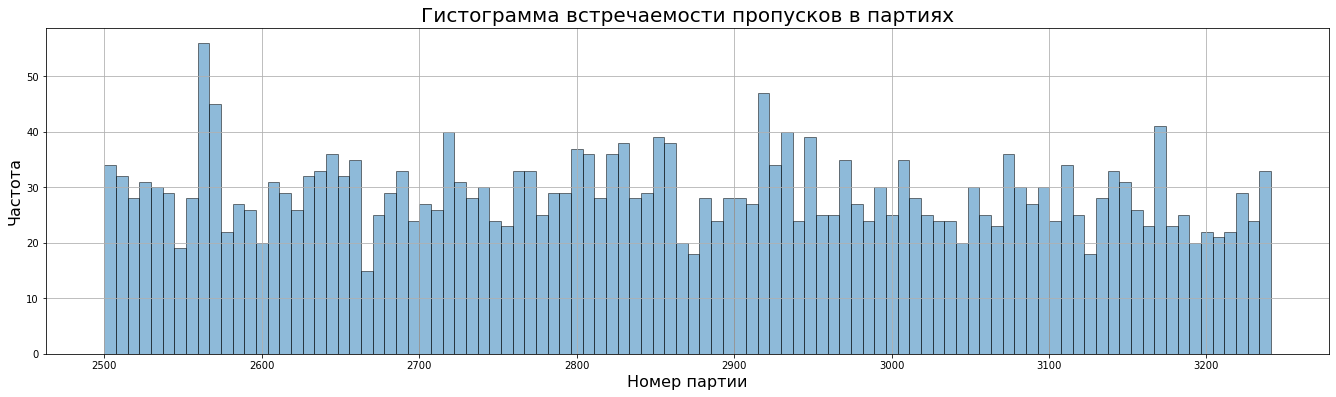

In [48]:
data_temp.loc[data_temp['Температура'].isnull(),'key'].plot.hist(bins=100, edgecolor='black', figsize=(23, 6), grid=True, alpha=0.5)
plt.title('Гистограмма встречаемости пропусков в партиях', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Номер партии', fontsize=16)

Как видно из гистограммы, партии с пропусками идут беспрерывно начинаюс 2500. В этих партиях только одна температура (начальная), а значит эти партии не годятся для ML. Удалим их в дальнейшем.

In [49]:
#Посмотрим количество пропусков
print("Число пропусков:")
print(data_temp.isnull().mean().sort_values()) 

Число пропусков:
key             0.000000
Время замера    0.000000
Температура     0.182373
dtype: float64


In [50]:
#Выведеим число полных дубликатов
print("Число полных дубликатов:", data_temp.duplicated().sum()) 

Число полных дубликатов: 0


In [51]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [52]:
#Посмотрим как температура меняется внутри одного Key
data_temp.dropna().groupby('key').std().dropna().describe()

,Температура
count,2475.000000
mean,10.715135
std,8.403257
min,0.000000
25%,6.082763
50%,9.549869
75%,13.703926
max,174.268471


In [53]:
data_temp=data_temp.dropna()

<a name="7"></a>
#### data_wire (данные о проволочных материалах -объём)

In [54]:
data_wire.sample(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3061,3222,25.072321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1711,1798,43.056000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325,351,69.264008,47.170239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2931,3090,166.202393,80.255760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2408,2535,33.109440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,77,110.292000,45.135998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
919,979,86.158799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,345,71.229599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
482,515,137.311203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2657,2796,170.308334,16.195919,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
#Посмотрим количество пропусков
print("Число пропусков:")
print(data_wire.isnull().mean().sort_values()) 

Число пропусков:
key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 6    0.976306
Wire 3    0.979552
Wire 9    0.990587
Wire 8    0.993833
Wire 4    0.995456
Wire 7    0.996430
Wire 5    0.999675
dtype: float64


In [56]:
#Заполним пропуски нулями
data_wire = data_wire.fillna(0)

In [57]:
data_wire['total_wire']=data_wire['Wire 1']+data_wire['Wire 2']+data_wire['Wire 3']+data_wire['Wire 4']+data_wire['Wire 5']+data_wire['Wire 6']+data_wire['Wire 7']+data_wire['Wire 8']+data_wire['Wire 9']

In [58]:
#Удалим колонки с числом пропуском более 99%
data_wire = data_wire.drop(['Wire 5','Wire 7','Wire 4','Wire 8','Wire 9'], axis=1)

<a name="8"></a>
#### data_wire_time (данные о проволочных материалах- время)

In [59]:
data_wire_time.sample(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2789,2942,2019-08-22 08:16:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
888,948,2019-06-07 12:41:15,2019-06-07 12:42:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
775,828,2019-06-03 02:37:07,2019-06-03 02:37:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
553,588,2019-05-25 03:04:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2170,2281,2019-07-29 07:36:49,2019-07-29 07:37:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2583,2717,2019-08-13 18:38:25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2546,2679,2019-08-12 12:40:54,2019-08-12 12:42:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1908,2002,2019-07-19 21:42:28,2019-07-19 21:43:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2436,2563,2019-08-08 10:43:20,NaN,2019-08-08 09:44:29,NaN,NaN,2019-08-08 09:35:19,2019-08-08 10:43:30,NaN,NaN
80,95,2019-05-06 16:24:20,2019-05-06 16:30:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
#Посмотрим количество пропусков
print("Число пропусков:")
print(data_wire_time.isnull().mean().sort_values())

Число пропусков:
key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 6    0.976306
Wire 3    0.979552
Wire 9    0.990587
Wire 8    0.993833
Wire 4    0.995456
Wire 7    0.996430
Wire 5    0.999675
dtype: float64


In [61]:
#Удалим колонки с числом пропуском более 99%
data_wire_time = data_wire_time.drop(['Wire 5','Wire 7','Wire 4','Wire 8','Wire 9'], axis=1)

In [62]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 6  73 non-null     object
dtypes: int64(1), object(4)
memory usage: 120.5+ KB


In [63]:
#Приведем тип данных к datetime
data_wire_time.iloc[:,1:] = data_wire_time.iloc[:,1:].apply(pd.to_datetime, errors='coerce')

<a name="10"></a>
#### Объединение таблиц

In [64]:
data_arc.sample(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Длительность нагрева
5501,1196,2019-06-15 15:58:07,2019-06-15 16:00:45,0.701735,0.523909,0.875736,158.0
8810,1917,2019-07-15 22:03:50,2019-07-15 22:06:59,0.794601,0.524623,0.952166,189.0
5564,1209,2019-06-16 02:54:47,2019-06-16 02:59:37,1.191074,0.882556,1.482418,290.0
12832,2789,2019-08-16 15:04:00,2019-08-16 15:05:14,0.253420,0.173872,0.307332,74.0
13562,2943,2019-08-22 08:53:59,2019-08-22 08:57:13,0.669105,0.532844,0.855351,194.0
5560,1208,2019-06-16 02:15:54,2019-06-16 02:22:29,1.382648,1.056924,1.740346,395.0
22,6,2019-05-03 13:46:51,2019-05-03 13:48:34,0.334140,0.230438,0.405896,103.0
11046,2403,2019-08-02 20:27:25,2019-08-02 20:30:37,0.697044,0.491409,0.852850,192.0
9832,2130,2019-07-24 11:34:56,2019-07-24 11:38:46,1.109041,0.659219,1.290172,230.0
5143,1118,2019-06-13 00:54:02,2019-06-13 00:56:04,0.417712,0.363337,0.553622,122.0


In [65]:
data_arc=data_arc.pivot_table(index='key', aggfunc={'Активная мощность': ('count', 'mean'),
             'Реактивная мощность': 'mean',
             'Длительность нагрева': 'sum', 
             'Полная мощность': 'mean',
             'Начало нагрева дугой': 'min',
             'Конец нагрева дугой': 'max'}
    )

In [66]:
data_arc

Активная мощность           Длительность нагрева Конец нагрева дугой  \
                 count      mean                  sum                 max   
key                                                                         
1                    5  0.975629               1098.0 2019-05-03 11:28:37   
2                    4  0.763150                811.0 2019-05-03 11:53:18   
3                    5  0.505176                655.0 2019-05-03 12:32:19   
4                    4  0.802313                741.0 2019-05-03 12:57:50   
5                    4  0.836793                869.0 2019-05-03 13:33:55   
...                ...       ...                  ...                 ...   
3237                 5  0.786493                909.0 2019-08-31 23:03:48   
3238                 3  0.702176                546.0 2019-08-31 23:41:28   
3239                 8  0.583344               1216.0 2019-09-01 02:15:43   
3240                 5  0.596817                839.0 2019-09-01 03:34:08   
3241                 5  0.494289                659.0 2019-09-01 04:36:08   

     Начало нагрева дугой Полная мощность Реактивная мощность  
                      min            mean                mean  
key                                                            
1     2019-05-03 11:02:14        1.165279            0.636648  
2     2019-05-03 11:34:14        0.912304            0.499528  
3     2019-05-03 12:06:54        0.597907            0.319815  
4     2019-05-03 12:39:37        0.953741            0.515074  
5     2019-05-03 13:11:13        1.008939            0.563161  
...                   ...             ...                 ...  
3237  2019-08-31 22:41:18        0.968996            0.565692  
3238  2019-08-31 23:26:18        0.898847            0.560394  
3239  2019-09-01 01:26:53        0.701485            0.388952  
3240  2019-09-01 02:35:24        0.778371            0.496653  
3241  2019-09-01 03:58:58        0.599903            0.339240  

[3214 rows x 7 columns]

In [67]:
data_arc.columns=data_arc.columns.droplevel()

In [68]:
data_arc.set_axis(['heat_count', 'active_power_mean', 'heat_time', 'heat_begin_time',
                          'heat_end_time', 'full_power_mean', 'reactive_power_mean'], axis='columns', inplace=True)


In [69]:
data_arc.sample(10)

,heat_count,active_power_mean,heat_time,heat_begin_time,heat_end_time,full_power_mean,reactive_power_mean
key,,,,,,,
476,5,1.022446,1175.0,2019-05-21 03:37:44,2019-05-21 02:42:33,1.258458,0.731328
1922,5,0.643321,844.0,2019-07-16 02:54:31,2019-07-16 02:30:22,0.794691,0.466532
83,4,1.102257,1002.0,2019-05-06 07:56:59,2019-05-06 07:34:02,1.349330,0.777581
1021,7,0.511985,993.0,2019-06-09 20:32:52,2019-06-09 19:52:10,0.629873,0.366535
2977,4,0.628163,626.0,2019-08-23 12:47:18,2019-08-23 12:19:56,0.754704,0.417487
1315,6,0.549084,859.0,2019-06-19 17:06:35,2019-06-19 16:41:36,0.674566,0.391667
1355,6,0.660657,952.0,2019-06-21 09:30:42,2019-06-21 08:56:04,0.838618,0.514357
2652,6,0.668834,861.0,2019-08-11 15:13:03,2019-08-11 14:46:34,0.788748,0.416765
1332,3,0.895182,610.0,2019-06-20 05:54:58,2019-06-20 05:35:56,1.121274,0.671943


In [70]:
data_temp=data_temp.pivot_table(index=data_temp['key'],aggfunc={'Температура': ('first','last','mean')})
data_temp.columns= data_temp.columns.droplevel()
data_temp.sample(10)

,first,last,mean
key,,,
179,1602.0,1593.0,1595.166667
558,1568.0,1589.0,1583.666667
3056,1608.0,1608.0,1608.000000
2568,1625.0,1625.0,1625.000000
1464,1567.0,1585.0,1585.833333
2904,1558.0,1558.0,1558.000000
1656,1581.0,1580.0,1580.500000
39,1586.0,1602.0,1593.333333
2352,1571.0,1593.0,1586.333333


In [71]:
data_temp=data_temp.rename(columns={"first": "first_temp","last":"last_temp", "mean": "mean_temp"}, errors="raise")

In [72]:
data_for_ml=data_arc.join(other=data_temp,on='key', how='inner')

In [73]:
data_for_ml.drop(['heat_begin_time','heat_end_time'], axis=1, inplace=True)

In [74]:
data_for_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   heat_count           3214 non-null   int64  
 1   active_power_mean    3214 non-null   float64
 2   heat_time            3214 non-null   float64
 3   full_power_mean      3214 non-null   float64
 4   reactive_power_mean  3214 non-null   float64
 5   first_temp           3214 non-null   float64
 6   last_temp            3214 non-null   float64
 7   mean_temp            3214 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 226.0 KB


In [75]:
data_bulk=data_bulk.set_index('key')

In [76]:
data_for_ml=data_for_ml.join(other=data_bulk,on='key', how='inner')

In [77]:
data_gas=data_gas.set_index('key')

In [78]:
data_for_ml=data_for_ml.join(other=data_gas,on='key', how='inner')
data_for_ml.sample(10)

,heat_count,active_power_mean,heat_time,full_power_mean,reactive_power_mean,first_temp,last_temp,mean_temp,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,total_bulk,Газ 1
key,,,,,,,,,,,,,,,,,,,,
2283,3,0.687051,534.0,0.854529,0.507840,1594.0,1591.0,1591.500000,0.0,122.0,0.0,0.0,0.0,0.0,0.0,156.0,146.0,106.0,530.0,3.570013
1730,4,0.413788,428.0,0.531766,0.333437,1610.0,1592.0,1598.333333,27.0,156.0,0.0,0.0,0.0,0.0,0.0,345.0,177.0,125.0,830.0,11.903262
1265,3,0.478592,382.0,0.599493,0.360877,1644.0,1602.0,1616.000000,0.0,0.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,9.174237
1541,3,0.672158,519.0,0.798204,0.430489,1597.0,1591.0,1585.200000,0.0,0.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,8.956486
2588,4,0.847270,833.0,1.050532,0.616694,1562.0,1562.0,1562.000000,0.0,96.0,0.0,0.0,0.0,0.0,0.0,258.0,102.0,224.0,680.0,9.033905
1448,5,0.565258,704.0,0.681898,0.380896,1605.0,1595.0,1593.500000,0.0,0.0,146.0,0.0,0.0,0.0,0.0,256.0,120.0,203.0,725.0,7.683344
2650,4,0.698703,623.0,0.835544,0.456486,1566.0,1566.0,1566.000000,0.0,142.0,106.0,0.0,0.0,0.0,0.0,0.0,148.0,0.0,470.0,8.218532
1564,5,1.060869,1167.0,1.273290,0.703604,1629.0,1676.0,1662.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,435.0,198.0,0.0,633.0,7.517881
1657,5,0.415023,581.0,0.504912,0.287376,1566.0,1583.0,1569.200000,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,5.520561


In [79]:
data_wire=data_wire.set_index('key')
data_for_ml.sample(10)

,heat_count,active_power_mean,heat_time,full_power_mean,reactive_power_mean,first_temp,last_temp,mean_temp,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,total_bulk,Газ 1
key,,,,,,,,,,,,,,,,,,,,
97,6,0.626633,999.0,0.750216,0.412198,1603.0,1596.0,1592.625000,0.0,0.0,0.0,0.0,0.0,106.0,0.0,204.0,156.0,154.0,620.0,17.226811
834,6,0.581488,857.0,0.726868,0.435857,1564.0,1582.0,1574.400000,0.0,75.0,0.0,0.0,0.0,0.0,0.0,208.0,197.0,203.0,683.0,16.523095
2073,4,0.813396,830.0,1.024638,0.621242,1586.0,1607.0,1594.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,412.0,231.0,210.0,853.0,6.432211
1697,5,0.989862,1075.0,1.168486,0.619212,1538.0,1589.0,1585.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,401.0,188.0,168.0,757.0,7.745160
1550,7,0.475880,1053.0,0.602800,0.367899,1624.0,1602.0,1601.250000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,458.0,247.0,209.0,1004.0,10.605103
262,6,0.603147,953.0,0.747632,0.439877,1596.0,1596.0,1594.000000,0.0,0.0,116.0,0.0,0.0,0.0,0.0,413.0,252.0,153.0,934.0,22.259571
888,3,0.874110,605.0,1.101403,0.668995,1581.0,1593.0,1585.000000,0.0,188.0,0.0,0.0,0.0,0.0,0.0,309.0,197.0,167.0,861.0,7.954749
3095,3,0.693011,510.0,0.902413,0.574906,1582.0,1582.0,1582.000000,0.0,46.0,0.0,0.0,0.0,0.0,0.0,306.0,130.0,210.0,692.0,4.132038
1890,8,0.749368,1472.0,0.943821,0.572330,1571.0,1611.0,1598.285714,0.0,0.0,0.0,0.0,78.0,0.0,0.0,453.0,234.0,206.0,971.0,15.741721


In [80]:
data_for_ml=data_for_ml.join(other=data_wire,on='key', how='inner')
data_for_ml.sample(10)

,heat_count,active_power_mean,heat_time,full_power_mean,reactive_power_mean,first_temp,last_temp,mean_temp,Bulk 1,Bulk 3,...,Bulk 12,Bulk 14,Bulk 15,total_bulk,Газ 1,Wire 1,Wire 2,Wire 3,Wire 6,total_wire
key,,,,,,,,,,,,,,,,,,,,,
1164,4,0.949882,895.0,1.169830,0.682406,1566.0,1590.0,1580.000000,0.0,0.0,...,256.0,105.0,203.0,564.0,7.709344,112.132797,0.000000,0.0,0.0,112.132797
1343,4,0.531184,611.0,0.694414,0.445783,1583.0,1595.0,1585.250000,0.0,0.0,...,0.0,0.0,0.0,155.0,11.400793,122.990402,0.000000,0.0,0.0,122.990402
1037,3,0.714875,522.0,0.878326,0.509779,1600.0,1596.0,1594.000000,0.0,93.0,...,311.0,131.0,159.0,694.0,8.717571,104.083199,0.000000,0.0,0.0,104.083199
95,6,0.573582,1077.0,0.789090,0.539839,1598.0,1587.0,1584.625000,0.0,0.0,...,105.0,256.0,0.0,470.0,14.381483,75.260643,23.150400,0.0,0.0,98.411043
2547,5,0.900834,1159.0,1.093974,0.620655,1581.0,1581.0,1581.000000,0.0,202.0,...,106.0,98.0,208.0,812.0,11.836793,92.601593,25.032799,0.0,0.0,117.634392
3025,4,1.053020,963.0,1.309463,0.777449,1562.0,1562.0,1562.000000,0.0,0.0,...,414.0,150.0,260.0,824.0,6.669090,90.111839,0.000000,0.0,0.0,90.111839
379,4,0.573222,559.0,0.703867,0.407543,1615.0,1594.0,1599.500000,0.0,0.0,...,205.0,145.0,103.0,542.0,12.759209,166.280410,0.000000,0.0,0.0,166.280410
1815,5,0.560699,839.0,0.706658,0.428959,1608.0,1583.0,1582.857143,31.0,0.0,...,479.0,203.0,0.0,899.0,6.996337,134.175613,0.000000,0.0,0.0,134.175613
1538,5,0.576093,813.0,0.747763,0.472851,1558.0,1575.0,1571.333333,0.0,60.0,...,0.0,152.0,0.0,212.0,18.137567,0.000000,45.119358,0.0,0.0,45.119358


<a name="11"></a>
#### Корреляция

In [81]:
rs = np.random.RandomState(0)
df = data_for_ml
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,heat_count,active_power_mean,heat_time,full_power_mean,reactive_power_mean,first_temp,last_temp,mean_temp,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,total_bulk,Газ 1,Wire 1,Wire 2,Wire 3,Wire 6,total_wire
heat_count,1.000000,0.004150,0.779864,0.002070,-0.006212,-0.128143,0.062532,-0.077024,0.111385,0.105564,0.001870,0.097202,0.152429,0.007297,0.048157,0.271496,0.310747,0.141200,0.400397,0.413321,0.132253,0.078177,0.072509,0.094097,0.183104
active_power_mean,0.004150,1.000000,0.563799,0.988491,0.924210,-0.423005,-0.073852,-0.314751,0.022104,0.063209,-0.044654,-0.051475,0.016431,-0.019105,0.051195,0.403219,0.307525,0.342012,0.410995,0.074872,-0.070952,-0.010354,-0.017995,0.000381,-0.063541
heat_time,0.779864,0.563799,1.000000,0.568472,0.545541,-0.320502,0.023584,-0.219560,0.102211,0.099366,-0.024145,0.021628,0.142640,-0.011464,0.078292,0.457355,0.434426,0.280696,0.543806,0.389312,0.065875,0.048047,0.024289,0.046794,0.089030
full_power_mean,0.002070,0.988491,0.568472,1.000000,0.971109,-0.421012,-0.085307,-0.323208,0.032373,0.044475,-0.048485,-0.049851,0.011886,-0.022079,0.054985,0.403434,0.296485,0.331449,0.399455,0.067690,-0.089364,-0.013629,-0.023452,-0.001376,-0.079958
reactive_power_mean,-0.006212,0.924210,0.545541,0.971109,1.000000,-0.395758,-0.098956,-0.319539,0.049977,0.010445,-0.051891,-0.045072,0.003058,-0.026013,0.058187,0.386199,0.264196,0.301169,0.362858,0.051839,-0.115120,-0.019738,-0.031409,-0.004484,-0.103882
first_temp,-0.128143,-0.423005,-0.320502,-0.421012,-0.395758,1.000000,0.501236,0.790019,0.069467,-0.091386,0.132504,0.055752,-0.104132,0.041439,-0.090621,-0.070669,-0.124727,-0.044207,-0.084849,0.034913,0.196588,-0.090522,0.010519,0.026166,0.093496
last_temp,0.062532,-0.073852,0.023584,-0.085307,-0.098956,0.501236,1.000000,0.880439,-0.016357,-0.041298,0.141122,-0.016901,-0.143440,0.058145,-0.102287,0.113009,0.024962,0.123841,0.089900,0.043871,0.235651,-0.146710,-0.011732,-0.028907,0.063062
mean_temp,-0.077024,-0.314751,-0.219560,-0.323208,-0.319539,0.790019,0.880439,1.000000,0.030636,-0.076135,0.152472,0.020377,-0.146152,0.055443,-0.110174,0.005968,-0.068534,0.036767,-0.014172,0.038800,0.246132,-0.144030,0.001455,0.003279,0.087010
Bulk 1,0.111385,0.022104,0.102211,0.032373,0.049977,0.069467,-0.016357,0.030636,1.000000,-0.012642,0.046173,0.087341,0.007741,-0.028985,-0.039000,0.290436,0.186535,-0.009135,0.314463,0.240911,-0.003040,-0.014429,0.028292,0.153284,0.035372
Bulk 3,0.105564,0.063209,0.099366,0.044475,0.010445,-0.091386,-0.041298,-0.076135,-0.012642,1.000000,-0.282291,-0.006146,0.069157,-0.093256,-0.015887,0.012054,0.019451,-0.003834,0.220227,0.056306,0.046445,0.085722,-0.008043,0.010086,0.070581


Явных корреляций кроме мощностей и температур нет. Поэтому из мощности оставм только полную мощность. А из температур удалим среднюю температуру (это очевидный мультиколлинеарный признак)

In [82]:
data_for_ml = data_for_ml.drop(['active_power_mean','reactive_power_mean','mean_temp'], axis=1)

In [83]:
data_for_ml

,heat_count,heat_time,full_power_mean,first_temp,last_temp,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 12,Bulk 14,Bulk 15,total_bulk,Газ 1,Wire 1,Wire 2,Wire 3,Wire 6,total_wire
key,,,,,,,,,,,,,,,,,,,,,
1,5,1098.0,1.165279,1571.0,1613.0,0.0,0.0,43.0,0.0,0.0,...,206.0,150.0,154.0,553.0,29.749986,60.059998,0.00000,0.0,0.0,60.059998
2,4,811.0,0.912304,1581.0,1602.0,0.0,0.0,73.0,0.0,0.0,...,206.0,149.0,154.0,582.0,12.555561,96.052315,0.00000,0.0,0.0,96.052315
3,5,655.0,0.597907,1596.0,1599.0,0.0,0.0,34.0,0.0,0.0,...,205.0,152.0,153.0,544.0,28.554793,91.160157,0.00000,0.0,0.0,91.160157
4,4,741.0,0.953741,1601.0,1625.0,0.0,0.0,81.0,0.0,0.0,...,207.0,153.0,154.0,595.0,18.841219,89.063515,0.00000,0.0,0.0,89.063515
5,4,869.0,1.008939,1576.0,1602.0,0.0,0.0,78.0,0.0,0.0,...,203.0,151.0,152.0,584.0,5.413692,89.238236,9.11456,0.0,0.0,98.352796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,5,909.0,0.968996,1569.0,1569.0,0.0,170.0,0.0,0.0,0.0,...,252.0,130.0,206.0,758.0,5.543905,38.088959,0.00000,0.0,0.0,38.088959
3238,3,546.0,0.898847,1584.0,1584.0,0.0,126.0,0.0,0.0,0.0,...,254.0,108.0,106.0,594.0,6.745669,56.128799,0.00000,0.0,0.0,56.128799
3239,8,1216.0,0.701485,1598.0,1598.0,0.0,0.0,0.0,0.0,114.0,...,158.0,270.0,88.0,630.0,16.023518,143.357761,0.00000,0.0,0.0,143.357761


In [84]:
#Переименуем колонки
column_names=['heat_count', 'heat_time', 'full_power_mean', 'first_temp', 'last_temp',
       'bulk_1', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_10', 'bulk_11',
       'bulk_12', 'bulk_14', 'bulk_15', 'total_bulk', 'gas_1', 'wire_1',
       'wire_2', 'wire_3', 'wire_6', 'total_wire']

data_for_ml.columns = column_names

<a name="12"></a>

### Исследовательский анализ данных

<a name="14"></a>

#### Температура

Text(0.5, 0, 'Температура С')

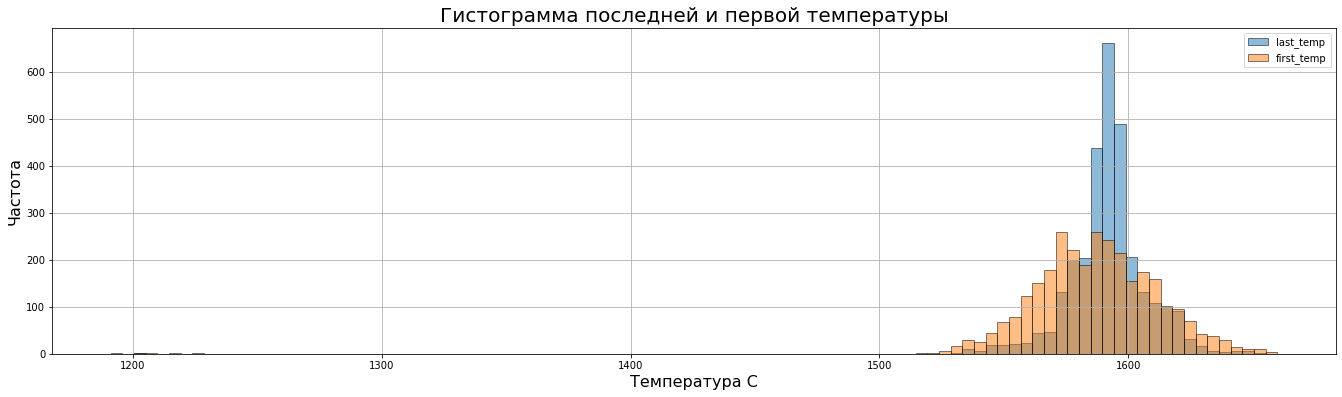

In [85]:
data_for_ml[['last_temp','first_temp']].plot.hist(bins=100, edgecolor='black', figsize=(23, 6), grid=True, alpha=0.5)
plt.title('Гистограмма последней и первой температуры', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Температура С', fontsize=16)

In [86]:
data_for_ml[['last_temp','first_temp']].describe()

,last_temp,first_temp
count,3022.000000,3022.000000
mean,1591.894441,1586.772005
std,16.644832,28.104700
min,1204.000000,1191.000000
25%,1585.000000,1571.000000
50%,1592.000000,1587.000000
75%,1599.000000,1603.000000
max,1653.000000,1660.000000


Text(0.5, 1.0, 'Диаграмма размаха конечной температуры')

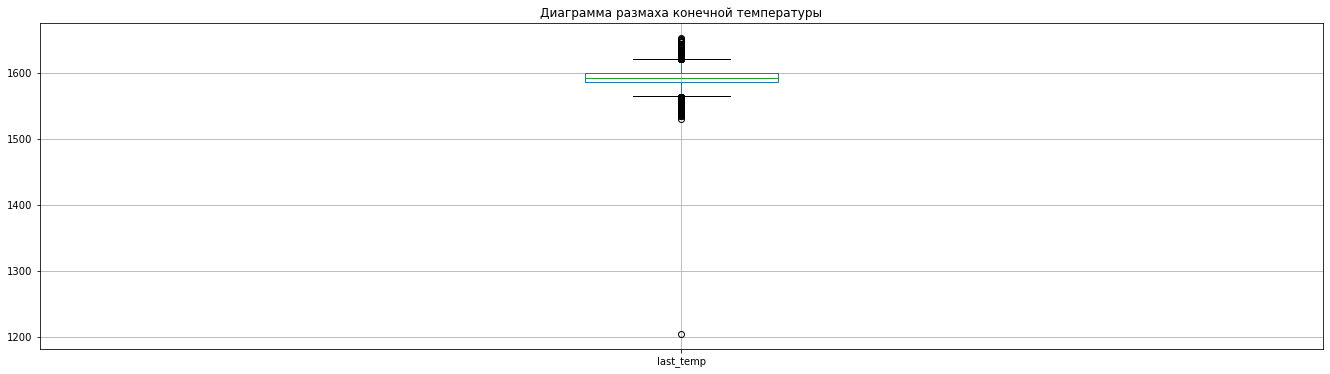

In [87]:
data_for_ml.boxplot(column='last_temp', figsize = (23,6))
plt.title('Диаграмма размаха конечной температуры')

In [88]:
data_for_ml['last_temp'].quantile(.01)

1545.0

In [89]:
data_for_ml=data_for_ml[data_for_ml['last_temp']>1545]

Text(0.5, 1.0, 'Диаграмма размаха конечной температуры')

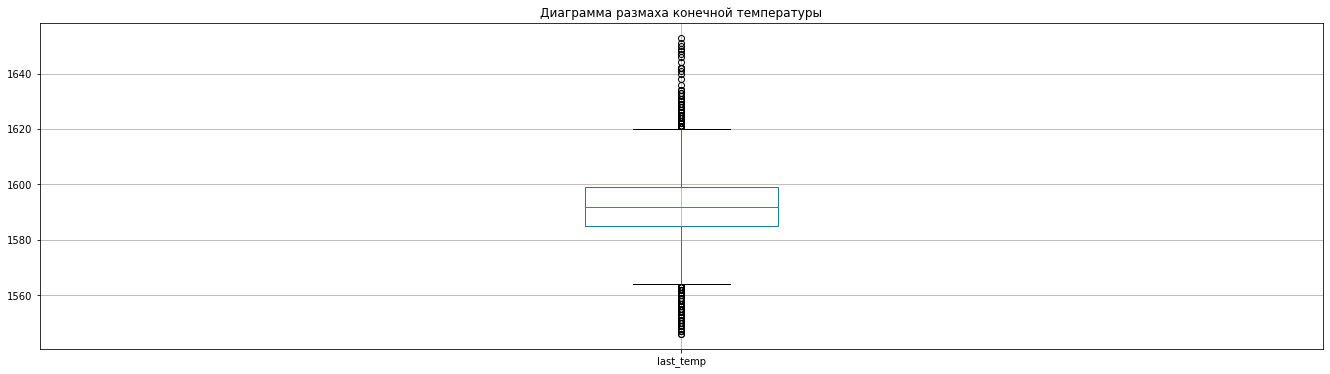

In [90]:
data_for_ml.boxplot(column='last_temp', figsize = (23,6))
plt.title('Диаграмма размаха конечной температуры')

1.Распределение начальной и конечной температуры соответствует нормальному распределению. 


2.Дисперсия у начальной температуры больше. чем у конечной.

In [91]:
#Удалим партии с номером больше 2500, где измерялась только начальная температура
data_for_ml=data_for_ml.loc[data_for_ml.index<2500]
data_for_ml.sample(10)

,heat_count,heat_time,full_power_mean,first_temp,last_temp,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,...,bulk_12,bulk_14,bulk_15,total_bulk,gas_1,wire_1,wire_2,wire_3,wire_6,total_wire
key,,,,,,,,,,,,,,,,,,,,,
791,6,1375.0,1.187064,1575.0,1595.0,0.0,143.0,0.0,0.0,0.0,...,363.0,213.0,196.0,915.0,12.045463,80.121597,40.173119,0.0,0.0,120.294716
177,6,991.0,0.741853,1579.0,1602.0,0.0,0.0,140.0,0.0,0.0,...,205.0,121.0,201.0,667.0,12.595186,116.276169,0.000000,0.0,0.0,116.276169
801,7,1361.0,0.993748,1638.0,1582.0,0.0,152.0,0.0,0.0,0.0,...,508.0,204.0,205.0,1069.0,10.867395,63.179999,36.403118,0.0,0.0,99.583117
265,5,787.0,0.796833,1563.0,1590.0,0.0,0.0,0.0,0.0,0.0,...,205.0,155.0,154.0,514.0,14.991407,62.200318,0.000000,0.0,0.0,62.200318
1942,7,1549.0,1.180726,1585.0,1611.0,0.0,122.0,0.0,0.0,0.0,...,360.0,160.0,212.0,854.0,6.473175,68.053436,0.000000,0.0,0.0,68.053436
1313,4,730.0,0.870615,1599.0,1611.0,0.0,62.0,0.0,0.0,0.0,...,0.0,0.0,0.0,62.0,9.704371,150.134399,0.060320,0.0,0.0,150.194719
105,3,574.0,0.955573,1585.0,1592.0,0.0,102.0,0.0,0.0,0.0,...,0.0,0.0,0.0,102.0,11.767225,115.184151,0.000000,0.0,0.0,115.184151
1069,4,668.0,0.899467,1580.0,1591.0,0.0,251.0,0.0,0.0,0.0,...,206.0,134.0,103.0,694.0,25.255937,76.190407,0.000000,0.0,0.0,76.190407
1484,5,709.0,0.752655,1557.0,1586.0,0.0,43.0,170.0,0.0,0.0,...,205.0,131.0,105.0,654.0,9.605658,102.117604,0.000000,0.0,0.0,102.117604


<a name="15"></a>
#### Сыпучие материалы

Text(0.5, 0, 'Объем подачи, ед.')

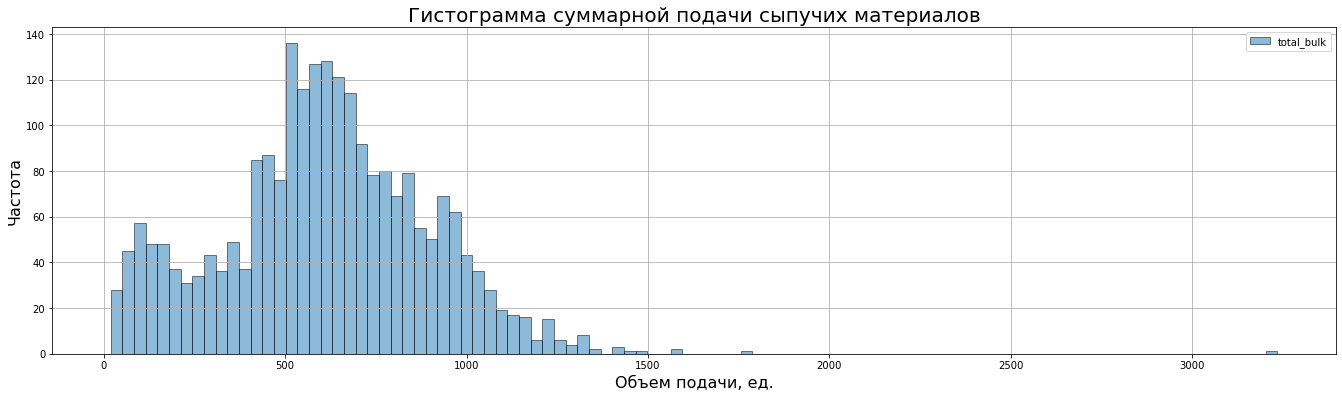

In [92]:
data_for_ml[['total_bulk']].plot.hist(bins=100, edgecolor='black', figsize=(23, 6), grid=True, alpha=0.5)
plt.title('Гистограмма суммарной подачи сыпучих материалов', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Объем подачи, ед.', fontsize=16)

Похоже что у нас есть выбросы в подаче сыпучих материалов.

In [93]:
data_bulk.describe()

,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,total_bulk
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,47.240332,33.830617,2.633749,21.892298,4.684564,4.345478,203.948226,152.706616,115.319271,595.503356
std,11.869164,74.239954,56.034505,20.918138,55.492582,20.157323,22.699580,151.419639,81.091421,84.488698,276.557794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,104.000000,0.000000,429.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,148.000000,106.000000,591.000000
75%,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,263.000000,202.000000,204.000000,772.000000
max,185.000000,454.000000,281.000000,603.000000,503.000000,159.000000,313.000000,1849.000000,636.000000,405.000000,3235.000000


In [94]:
data_bulk['total_bulk'].quantile(.99)

1232.9199999999978

Text(0.5, 1.0, 'Диаграмма размаха подачи сыпучих материалов')

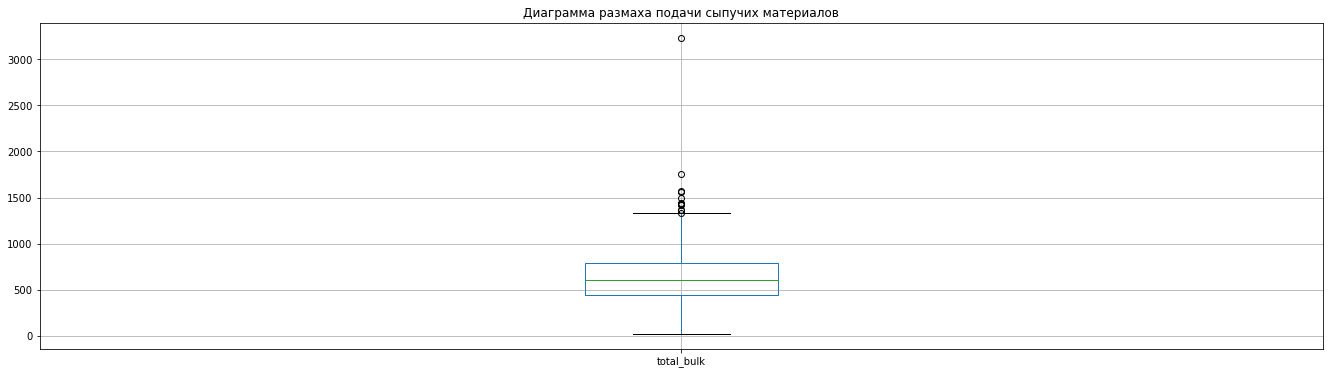

In [95]:
data_for_ml.boxplot(column='total_bulk', figsize = (23,6))
plt.title('Диаграмма размаха подачи сыпучих материалов')

In [96]:
data_bulk.loc[data_bulk['total_bulk']>1500]

,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,total_bulk
key,,,,,,,,,,,
322,185.0,101.0,58.0,0.0,0.0,0.0,0.0,1849.0,636.0,0.0,3235.0
327,67.0,0.0,119.0,0.0,0.0,0.0,0.0,775.0,403.0,205.0,1569.0
1689,0.0,0.0,0.0,0.0,247.0,0.0,0.0,733.0,248.0,224.0,1757.0
1999,54.0,0.0,0.0,0.0,0.0,0.0,0.0,853.0,366.0,290.0,1563.0


In [97]:
data_for_ml.shape

(2326, 22)

In [98]:
#Удалим выбросы, не включая весь 99% квантиль, а выберем 1500 (так как мы не можем запросить доп. тех информации, будем осторожными с данными)
data_for_ml=data_for_ml[data_for_ml['total_bulk']<1500]
data_for_ml.shape

(2322, 22)

<a name="16"></a>
#### Добавление газа

Text(0.5, 0, 'Объем подачи, ед.')

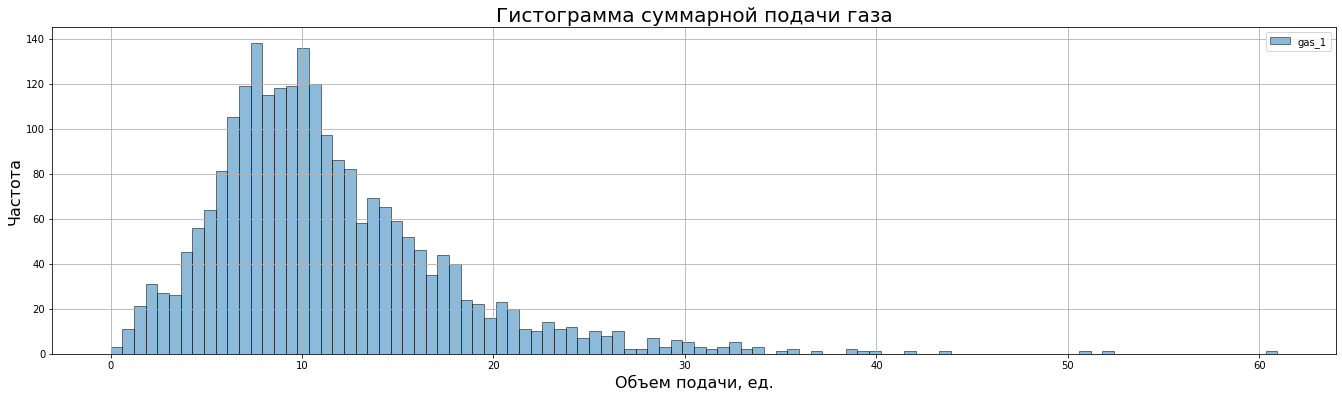

In [99]:
data_for_ml[['gas_1']].plot.hist(bins=100, edgecolor='black', figsize=(23, 6), grid=True, alpha=0.5)
plt.title('Гистограмма суммарной подачи газа', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Объем подачи, ед.', fontsize=16)

In [100]:
data_for_ml['gas_1'].describe()

count    2322.000000
mean       11.315547
std         6.176665
min         0.008399
25%         7.281707
50%        10.096395
75%        14.180317
max        60.935689
Name: gas_1, dtype: float64

Text(0.5, 1.0, 'Диаграмма размаха подачи газа')

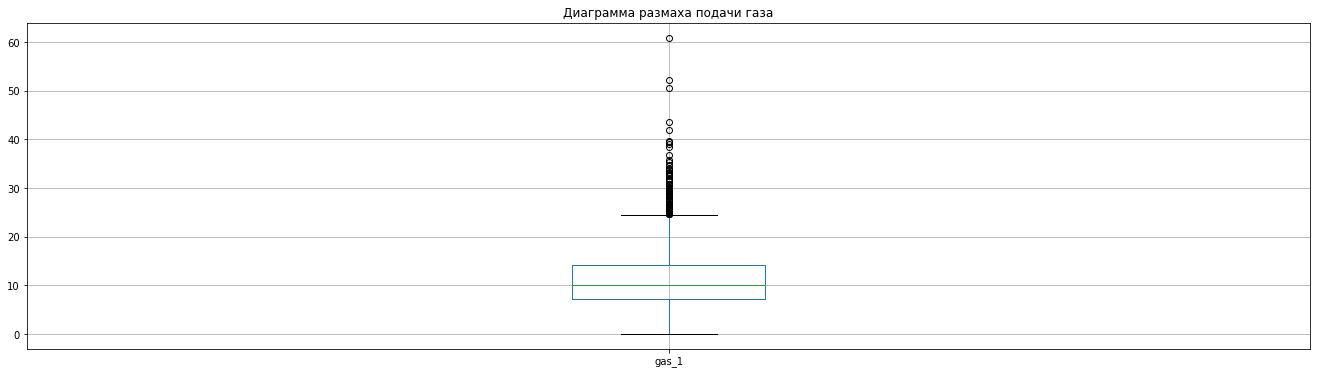

In [101]:
data_for_ml.boxplot(column='gas_1', figsize = (23,6))
plt.title('Диаграмма размаха подачи газа')

In [102]:
data_for_ml['gas_1'].quantile(.99)

31.959352932021

In [103]:
data_for_ml=data_for_ml[data_for_ml['gas_1']<40]
data_for_ml.shape

(2317, 22)

<a name="17"></a>
#### Количество нагревов

Text(0.5, 0, 'Объем подачи, ед.')

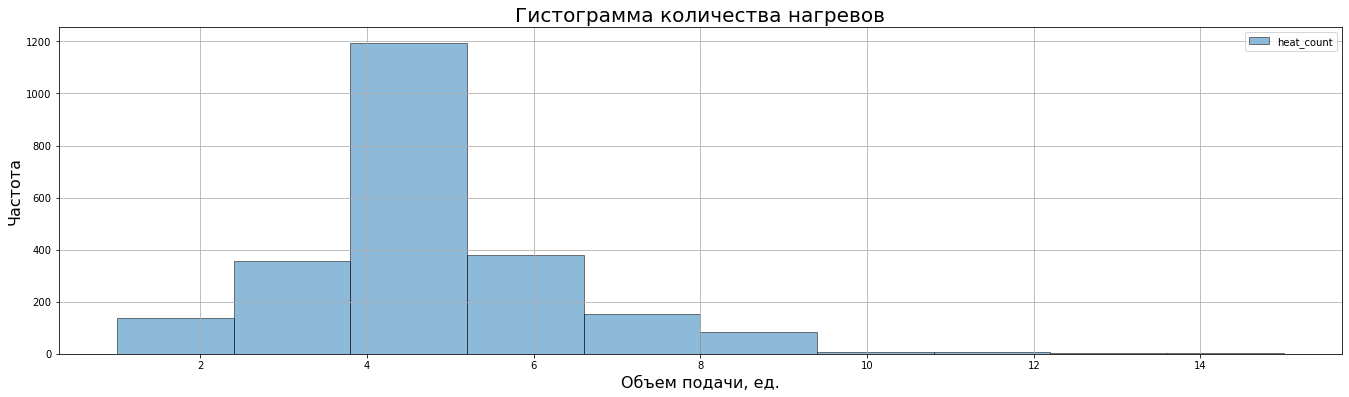

In [104]:
data_for_ml[['heat_count']].plot.hist(bins=10, edgecolor='black', figsize=(23, 6), grid=True, alpha=0.5)
plt.title('Гистограмма количества нагревов', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Объем подачи, ед.', fontsize=16)

In [105]:
print("Количество строк с числом измерений '1':",len(data_for_ml.loc[data_for_ml['heat_count']==1]))

Количество строк с числом измерений '1': 25


In [106]:
#Удалим такие стркои
data_for_ml=data_for_ml.loc[~(data_for_ml['heat_count']==1)]

<a name="18"></a>
#### Количество проволочных материалов

Text(0.5, 0, 'Объем проволочных материалов, ед.')

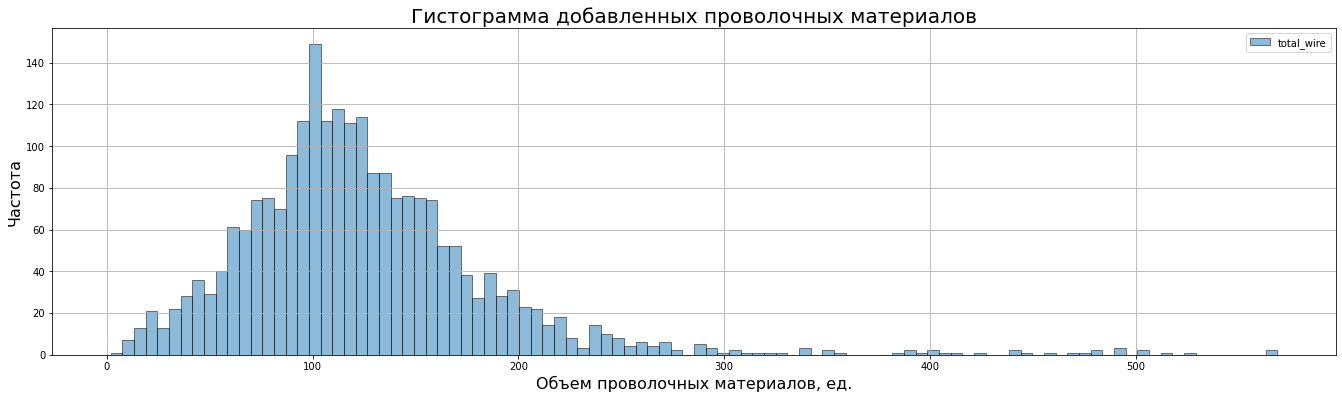

In [107]:
data_for_ml[['total_wire']].plot.hist(bins=100, edgecolor='black', figsize=(23, 6), grid=True, alpha=0.5)
plt.title('Гистограмма добавленных проволочных материалов', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Объем проволочных материалов, ед.', fontsize=16)

In [108]:
data_for_ml['total_wire'].quantile(.99)

392.0653449700001

In [109]:
data_for_ml['total_wire'].describe()

count    2292.000000
mean      124.839586
std        63.282481
min         1.918800
25%        88.451477
50%       116.038002
75%       151.340284
max       568.777664
Name: total_wire, dtype: float64

In [110]:
data_for_ml=data_for_ml[data_for_ml['total_wire']<data_for_ml['total_wire'].quantile(.99)]

Распределение похоже на нормальное, с правым хвостом. Мы наверняка не знаем, что означают значения в правом хвосте. насколько они легитимны. Поэтому оставим их

In [111]:
data_for_ml.sample(10)

,heat_count,heat_time,full_power_mean,first_temp,last_temp,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,...,bulk_12,bulk_14,bulk_15,total_bulk,gas_1,wire_1,wire_2,wire_3,wire_6,total_wire
key,,,,,,,,,,,,,,,,,,,,,
1616,6,1676.0,1.282612,1563.0,1617.0,31.0,87.0,0.0,0.0,0.0,...,411.0,302.0,208.0,1039.0,1.810480,187.199998,30.069521,0.000000,0.000000,217.269519
1898,5,1146.0,1.205438,1551.0,1593.0,0.0,0.0,0.0,0.0,72.0,...,0.0,248.0,0.0,341.0,13.154829,15.069599,0.000000,0.000000,0.000000,15.069599
1051,7,1992.0,1.535516,1554.0,1621.0,0.0,0.0,243.0,0.0,0.0,...,462.0,210.0,205.0,1120.0,16.447339,121.165196,0.000000,0.000000,0.000000,121.165196
1492,7,1480.0,0.973991,1606.0,1623.0,0.0,0.0,0.0,0.0,0.0,...,412.0,205.0,210.0,932.0,25.689534,215.373596,0.000000,0.000000,0.000000,215.373596
2163,3,291.0,0.460463,1611.0,1586.0,0.0,142.0,21.0,0.0,0.0,...,0.0,0.0,0.0,163.0,6.959038,75.042236,0.000000,0.000000,0.000000,75.042236
1721,6,912.0,0.567713,1615.0,1610.0,27.0,171.0,23.0,0.0,0.0,...,461.0,298.0,103.0,1083.0,13.912360,90.090004,0.000000,0.000000,0.000000,90.090004
113,4,819.0,1.116658,1645.0,1647.0,0.0,0.0,0.0,72.0,0.0,...,0.0,0.0,0.0,300.0,25.377930,7.556640,0.000000,96.047951,60.094322,187.847714
257,3,371.0,0.525262,1606.0,1591.0,0.0,0.0,26.0,0.0,0.0,...,203.0,155.0,155.0,539.0,10.017504,84.171356,0.000000,0.000000,0.000000,84.171356
676,4,644.0,0.716919,1586.0,1593.0,0.0,0.0,258.0,0.0,0.0,...,205.0,157.0,153.0,773.0,2.876526,93.272400,0.000000,0.000000,0.000000,93.272400


<a name="13"></a>

## Обучение и проверка моделей

<a name="19"></a>
#### Разделение датасета на тренировочную и валидационную выборку

In [112]:
# разбиваем на train/test
target = data_for_ml['last_temp']
features=data_for_ml.drop('last_temp',axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=123)


In [113]:
#Проверим размеры выборок перед обучением
print(data_for_ml.shape)
print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)

(2269, 22)
(1701, 21)
(568, 21)
(1701,)
(568,)


<a name="20"></a>
#### Линейная регрессия

In [114]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)

In [115]:
%%time
model_lin_regression = LinearRegression()
model_lin_regression.fit(features_train, target_train)
predictions=model_lin_regression.predict(features_valid)
lin_reg_mae=mean_absolute_error(target_valid, predictions)
print("MAE на валидационной выборке для LinearRegression:", lin_reg_mae)

MAE на валидационной выборке для LinearRegression: 6.0742627588450695
Wall time: 8.97 ms


<a name="21"></a>
#### Дерево решений

In [116]:
%%time
parameters = {'max_depth':range(1,80,1)}
dcs_tr_rgr = RandomizedSearchCV(DecisionTreeRegressor(random_state = 12345,criterion='mae'), parameters, cv=5, random_state=12345)
dcs_tr_rgr.fit(features_train, target_train)
print('Лучшие параметры: ',dcs_tr_rgr.best_params_)

Лучшие параметры:  {'max_depth': 5}
Wall time: 9.04 s


In [117]:
model_best=dcs_tr_rgr.best_estimator_
predictions=model_best.predict(features_valid)
dcs_tr_rgr_mae=mean_absolute_error(target_valid, predictions)
print("MAE на валидационной выборке для DecisionTreeRegressor:", dcs_tr_rgr_mae)

MAE на валидационной выборке для DecisionTreeRegressor: 6.689260563380282


<a name="22"></a>
#### Случайный лес

In [118]:
%%time
parameters = {'max_depth':range(1,80,1), 'n_estimators':range(10,51,3)}
rgr_rand_frst = RandomizedSearchCV(RandomForestRegressor(random_state = 12345,criterion='mae'), parameters, cv=5,random_state = 12345,n_jobs=-1)
rgr_rand_frst.fit(features_train, target_train)
print('Лучшие параметры: ',rgr_rand_frst.best_params_)
print('Параметры: ',rgr_rand_frst.best_estimator_)

Лучшие параметры:  {'n_estimators': 49, 'max_depth': 55}
Параметры:  RandomForestRegressor(criterion='mae', max_depth=55, n_estimators=49,
                      random_state=12345)
Wall time: 30 s


In [119]:
model_best=rgr_rand_frst.best_estimator_
predictions=model_best.predict(features_valid)
rgr_rand_frst_mae=mean_absolute_error(target_valid, predictions)
print("MAE на валидационной выборке для RandomForestRegressor:", rgr_rand_frst_mae)

MAE на валидационной выборке для RandomForestRegressor: 6.030863753952279


<a name="23"></a>
#### LightGBM

In [120]:
%%time
parameters = { 'metric': ['mae'],
                  'boosting_type': ['gbdt'],
                  'learning_rate': [0.01,0.03,0.05],
                  'n_estimators': range(2500,3500,100), #, 3000
                  'max_depth': range(5,25,1)} #3, 
lgbm_regr= RandomizedSearchCV(LGBMRegressor(random_state = 12345), parameters, cv=5, random_state=12345, n_jobs=-1)
lgbm_regr.fit(features_train, target_train)
print('Лучшие параметры: ',lgbm_regr.best_params_)
print('Параметры: ',lgbm_regr.best_estimator_)

Лучшие параметры:  {'n_estimators': 2500, 'metric': 'mae', 'max_depth': 23, 'learning_rate': 0.01, 'boosting_type': 'gbdt'}
Параметры:  LGBMRegressor(learning_rate=0.01, max_depth=23, metric='mae', n_estimators=2500,
              random_state=12345)
Wall time: 27.7 s


In [121]:
model_best=lgbm_regr.best_estimator_
predictions=model_best.predict(features_valid)
lgbm_regr_mae=mean_absolute_error(target_valid, predictions)
print("MAE на валидационной выборке для LGBMRegressor:",lgbm_regr_mae )

MAE на валидационной выборке для LGBMRegressor: 5.912597318119281


<AxesSubplot:>

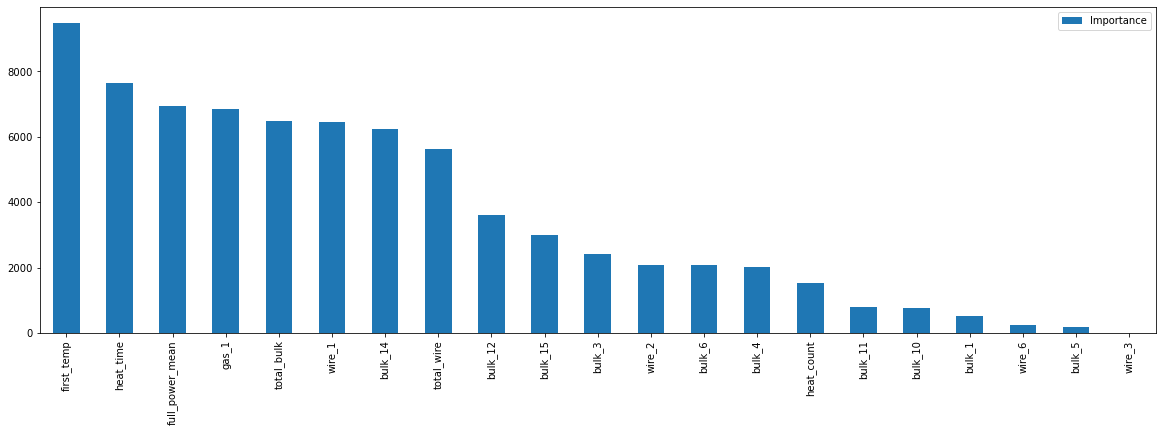

In [122]:
feat_importances = pd.DataFrame(model_best.feature_importances_, index=features.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(20,6))

<a name="24"></a>
#### Dummy Regressor

In [123]:
dummy_regressor = DummyRegressor(strategy="median") 
dummy_regressor.fit(features_train,target_train)
dummy_pred = dummy_regressor.predict(features_valid)
dummy_regressor_mae=mean_absolute_error(target_valid, dummy_pred)
print("MAE на валидационной выборке для Dummy Regressor:", mean_absolute_error(target_valid, dummy_pred))                                                     

MAE на валидационной выборке для Dummy Regressor: 7.515845070422535


<a name="25"></a>
#### Итоговое сравнение

In [124]:
final_table = pd.DataFrame([[lin_reg_mae], [dcs_tr_rgr_mae],[rgr_rand_frst_mae],[lgbm_regr_mae],[dummy_regressor_mae]], 
                   columns=['MAE' ], index=['Линейная регрессия', 'Дерево решений','Случайный лес','Градиентный бустинг','Dummy Regressor'])
final_table

,MAE
Линейная регрессия,6.074263
Дерево решений,6.689261
Случайный лес,6.030864
Градиентный бустинг,5.912597
Dummy Regressor,7.515845


Самые лучшие показатели - у LGBM Regressor.

## Отчет по решению задачи

1.При решении данной задачи были выполнены все пункты. Пункт 5 был выполнен не до конца - были обучены лишь 4 модели вместо 5-6.Причина - экономия времени. Light GBM раньше использовался, и поэтому его было проще настроить.

2.При выполнении задачи возникли следующие трудности:
-После удаления пропусков, группировки таблиц по key, mae получалось в районе 10, что очень далеко от целевого показателя около 6. Решение оказалось в подробном изучении таблицы с температурами, оказалось что последние 23% значений были с измерений только первой температуры, что не подходило для далнейшей работы.
-После удаления лишних партий с одним измерением, MAE не достигало целевых показателей. Помогла чистка датасета от выбросов.

3.Ключевые шаги в решении задачи:
-Подробное изучение физической сути исходных датасетов
-Построение графиков для наглядного понимания распределения параметров и взаимосвязи друг с другом
-Выбор модели путем подбора параметров с помощью RandomizedSearchCV


4.Итоговая модель - это Градиентный бустинг LightGBM, MAE - 5.91